In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader 

from sklearn.decomposition import PCA

import os
from tqdm import tqdm

from utils import visualize_batch
from utils import plot_loss_history
from utils import plot_latent_space
from utils import visualize_reconstruction
from utils import separate_by_class

# Dataloader

In [2]:
mnist_train = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [3]:
batch_size = 64
num_workers = 2

train_loader = DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, num_workers=num_workers, shuffle=True)
viz_loader = DataLoader(mnist_test, batch_size=60000, num_workers=num_workers, shuffle=True)

## Dataloader Visualizer

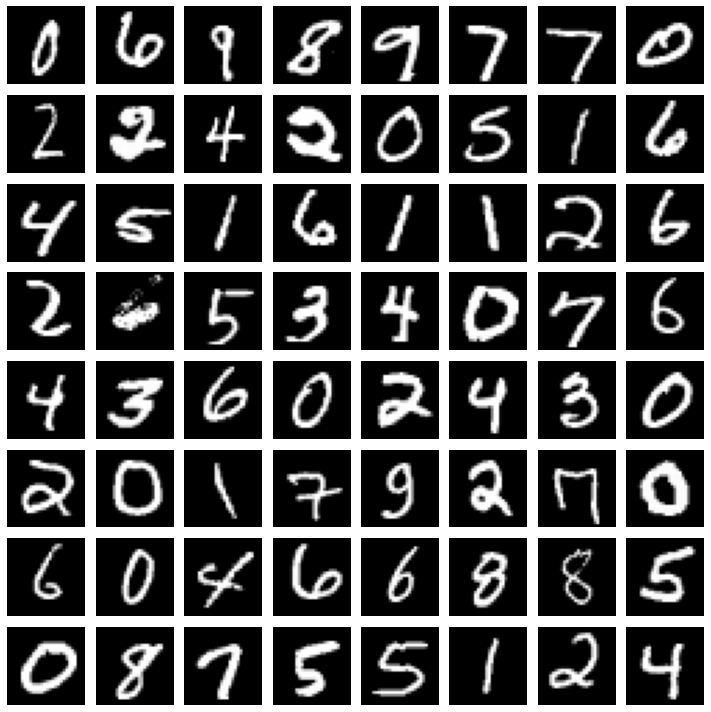

In [4]:
batch_to_viz = next(iter(train_loader))[0]
visualize_batch(batch_to_viz, num_images=64)

# Models

## Linear AE

In [5]:
class LAutoencoder(nn.Module):
    def __init__(self) -> None:
        super(LAutoencoder, self).__init__()
        self.latent = None
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.Linear(128, 32),
            nn.Linear(32, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.Linear(64, 128),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        self.latent = self.encoder(x)
        return self.decoder(self.latent)

## Non Linear AE

In [6]:
class NLAutoencoder(nn.Module):
    def __init__(self):
        super(NLAutoencoder, self).__init__()
        self.latent = None
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        self.latent = self.encoder(x)
        return self.decoder(self.latent)

# Train

In [7]:
def train(model, train_loader, criterion, optimizer):
    total_ep_loss = 0
    model.train()

    for i, (x, _) in enumerate(train_loader):
        x = x.view(x.shape[0], -1)  
        outputs = model(x)
        optimizer.zero_grad()
        loss = criterion(outputs, x)
        loss.backward()
        optimizer.step()   
        total_ep_loss += loss.item()
        if i == 0:
            f_pred = torch.cat((x[:2], outputs[:2]), dim=0)
    mean_ep_loss = total_ep_loss / len(train_loader)  
    return mean_ep_loss, f_pred

# Test

In [8]:
def test(model, test_loader, criterion):
    running_test_loss = 0
    model.eval()
    with torch.no_grad():
        for ep, (x, _) in enumerate(test_loader):
            x = x.view(x.shape[0], -1)
            outputs = model(x)
            loss = criterion(outputs, x)
            running_test_loss += loss.item()
    return running_test_loss / len(test_loader)

In [9]:
models = {"NLAE": {"model": NLAutoencoder(),
                   "latente_space": None, 
                   "output": None, 
                   "input_data_by_class": None,
                   "output_data_by_class": None},

           "LAE": {"model": LAutoencoder(), 
                   "latente_space": None, 
                   "output": None, 
                   "input_data_by_class": None,
                   "output_data_by_class": None}}

mse = nn.MSELoss()
opts = [torch.optim.Adam(ae["model"].parameters(), lr=0.002) for ae in models.values()]

In [10]:
def run_epochs(epochs, model, optimizer, model_type, criterion):
    infos = {"model": None, "model_type": model_type, "train_loss" : [], "test_loss": [], "f_pred": []}
    for epoch in tqdm(range(epochs)):
        train_loss, f_pred = train(model, train_loader, criterion, optimizer)
        test_loss = test(model, train_loader, criterion)

        infos["f_pred"].append(f_pred)
        infos["test_loss"].append(test_loss)
        infos["train_loss"].append(train_loss)

    model_path = os.path.join("models", model_type + ".pt")
    torch.save(models[model_type], model_path)
    infos["model"] = model
    return infos

In [11]:
os.makedirs("models") if not os.path.exists("models") else None
info_models = []
for i, (name, ae) in enumerate(models.items()):
    print(f"running {name} epochs")
    log = run_epochs(epochs=5, model=ae["model"], optimizer=opts[i], model_type=name, criterion=mse)
    info_models.append(log)

running NLAE epochs


100%|██████████| 5/5 [01:45<00:00, 21.04s/it]


running LAE epochs


100%|██████████| 5/5 [01:43<00:00, 20.65s/it]


# Reconstructions and Loss

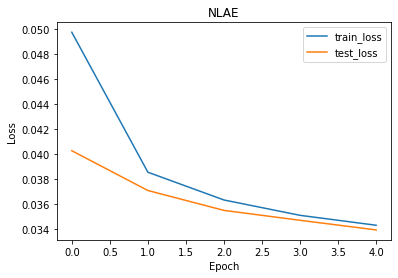

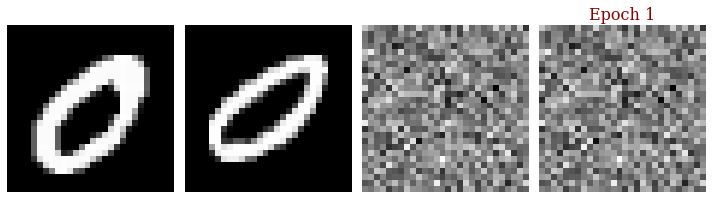

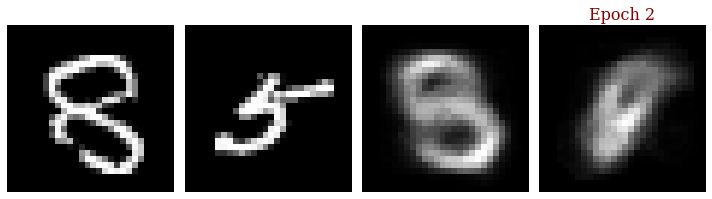

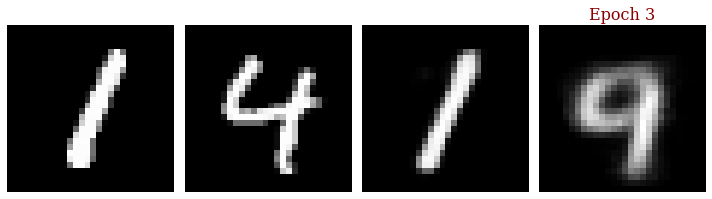

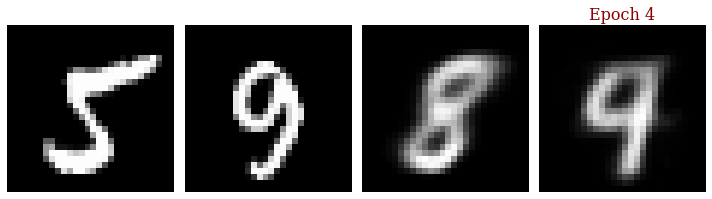

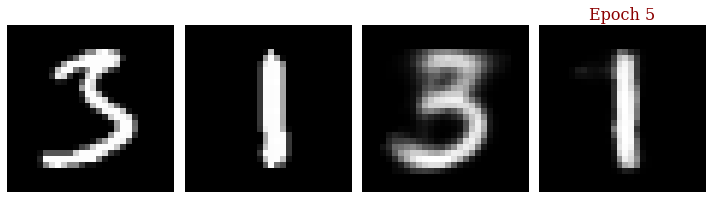

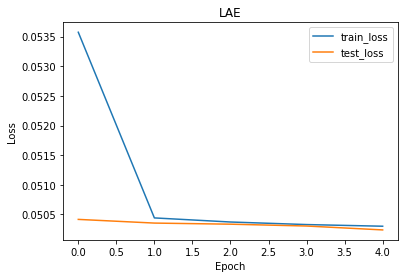

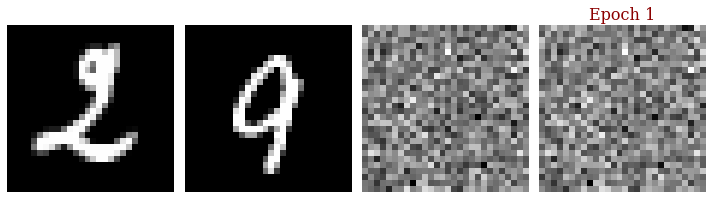

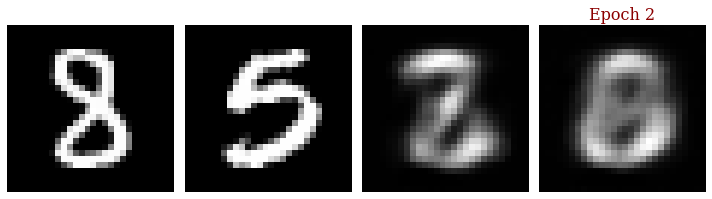

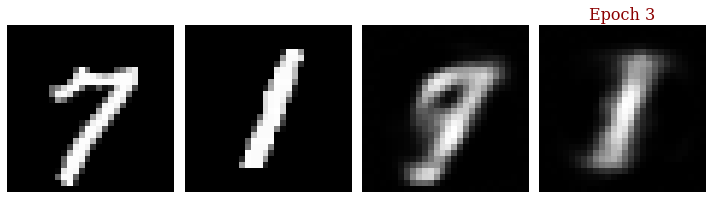

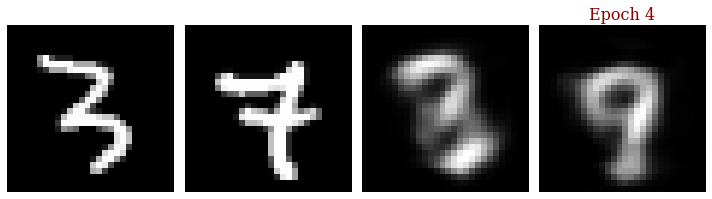

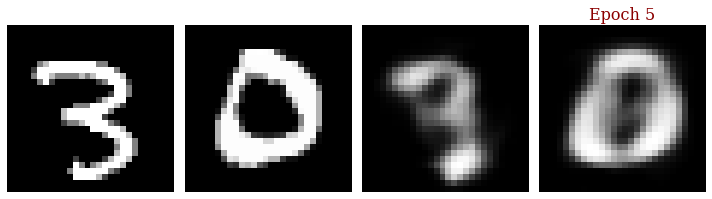

In [12]:
for info in info_models:
        plot_loss_history(info, model_type=info["model_type"])
        for i, preds in enumerate(info["f_pred"]):
                preds = preds.view(preds.shape[0], 28, 28).detach()
                visualize_batch(preds, text=f"{i+1}")

# PCA vs NLAE vs LAE 

In [13]:
models["PCA"] = {"model": PCA(n_components=3),
                 "latente_space": None, 
                 "output": None,
                 "input_data_by_class": None,
                 "output_data_by_class": None}

In [14]:
x, y = next(iter(viz_loader))
x = x.view(-1, 784)

for model_type in ["NLAE", "LAE", "PCA"]:
    model = models[model_type]["model"]
    if model_type == "PCA":
        model.fit(x.cpu())
        latent = model.transform(x.cpu())
        reconstruction = model.inverse_transform(latent)
    else:
        reconstruction = model(x).detach().cpu()
        latent = model.latent.detach().cpu()
    
    models[model_type]["latente_space"] = latent
    models[model_type]["output"] = reconstruction
    models[model_type]["input_data_by_class"] = separate_by_class(x, y)
    models[model_type]["output_data_by_class"] = separate_by_class(reconstruction, y)

torch.Size([10000, 3])


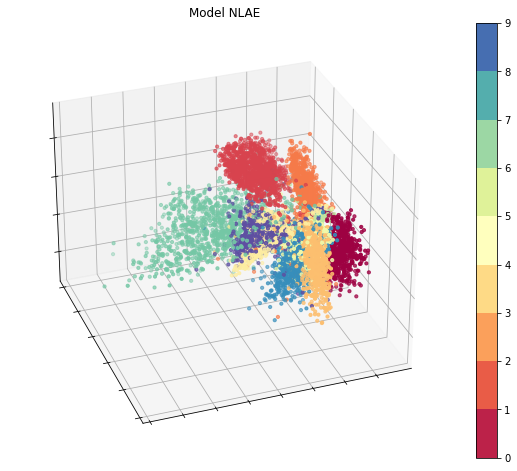

torch.Size([10000, 3])


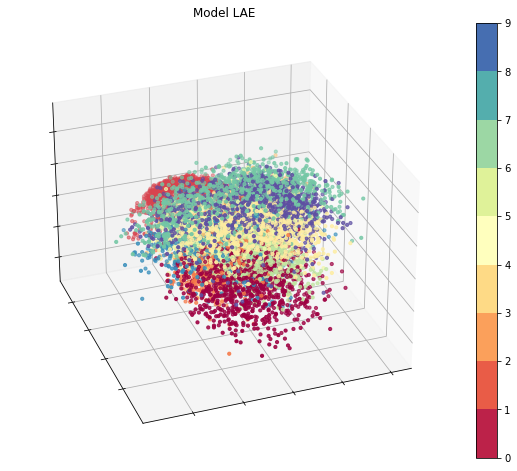

(10000, 3)


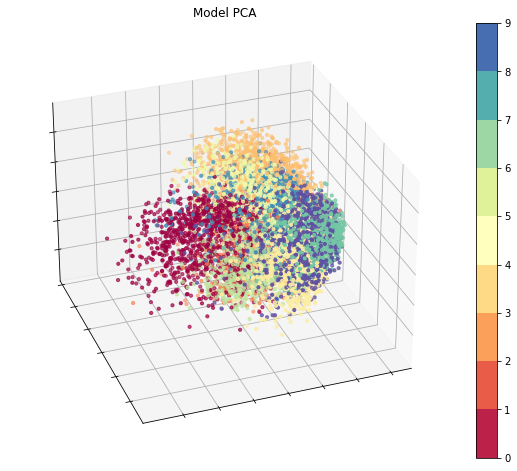

In [15]:
for model_type in ["NLAE", "LAE", "PCA"]:
    reconstruction = models[model_type]["output"]
    latent = models[model_type]["latente_space"]
    print(latent.shape)
    plot_latent_space(latent, model_type, y)

In [16]:
def visualize_reconstruction(original, out, labels, model_type):
    n = 8
    plt.figure(figsize=(20, 5))
    plt.suptitle(f"{model_type} Reconstruction", fontsize=16)
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.title(int(labels[i]))
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        r = out[i].reshape(28, 28) if model_type == "PCA" else out[i].reshape(28, 28)

        plt.imshow(r)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

## Overview Reconstructions

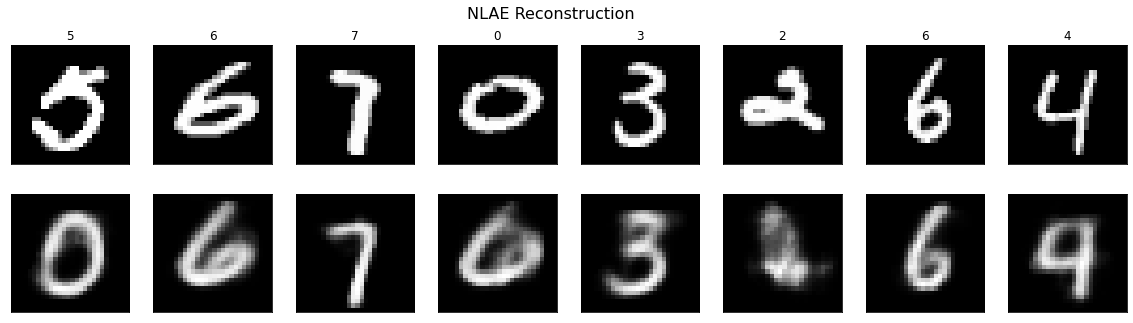

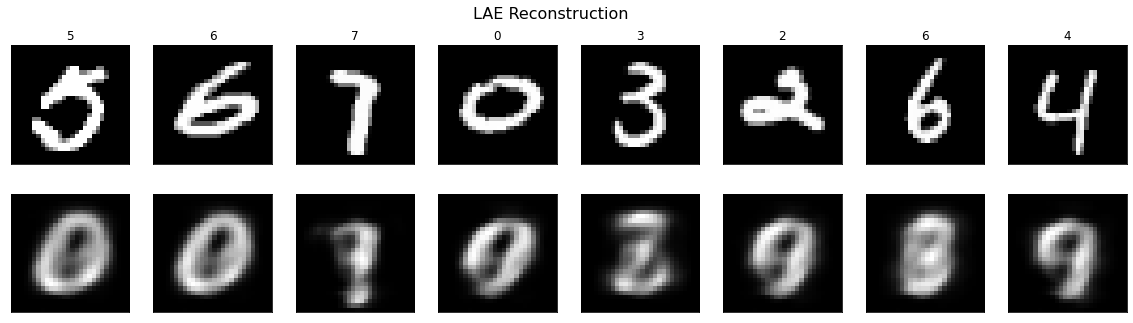

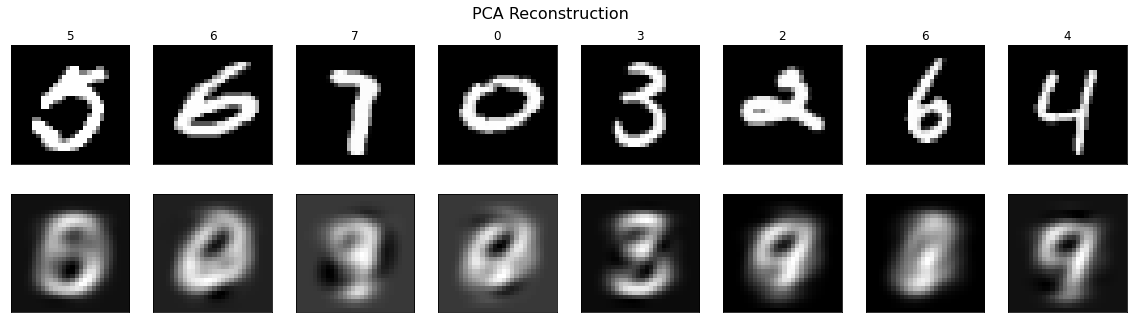

In [17]:
for model_type in ["NLAE", "LAE", "PCA"]:
    reconstructed = models[model_type]["output"]
    visualize_reconstruction(x, reconstructed, labels=y, model_type=model_type)

## Reconstructions by Class

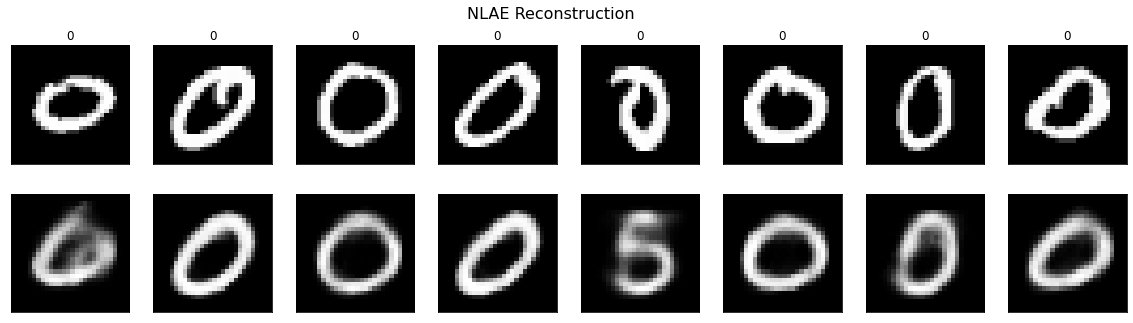

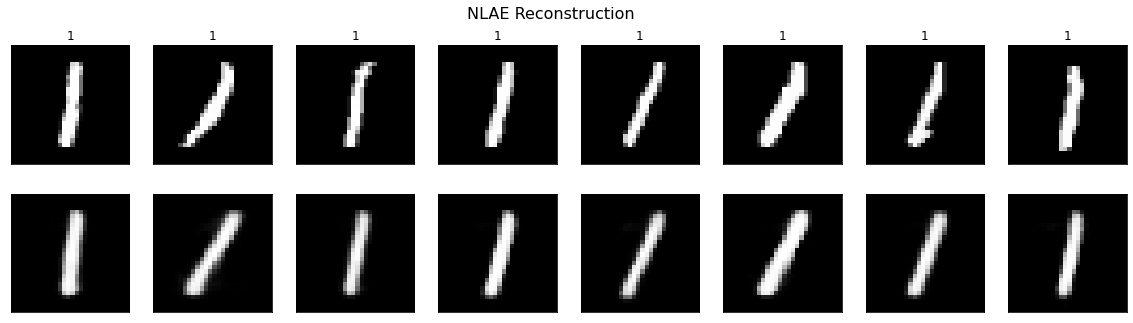

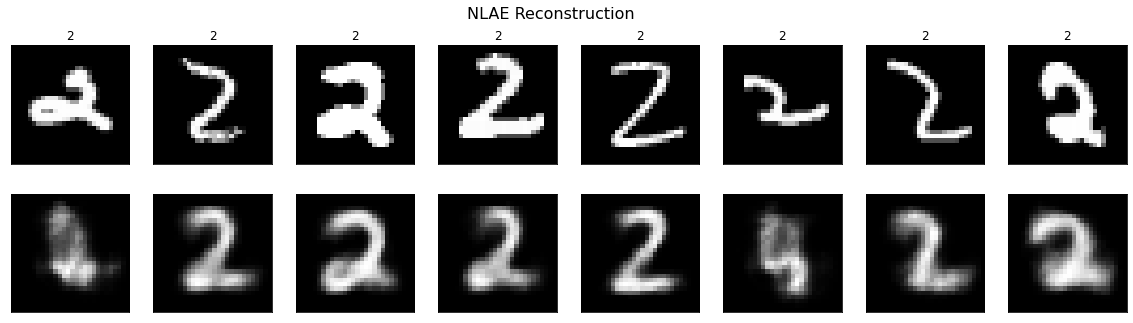

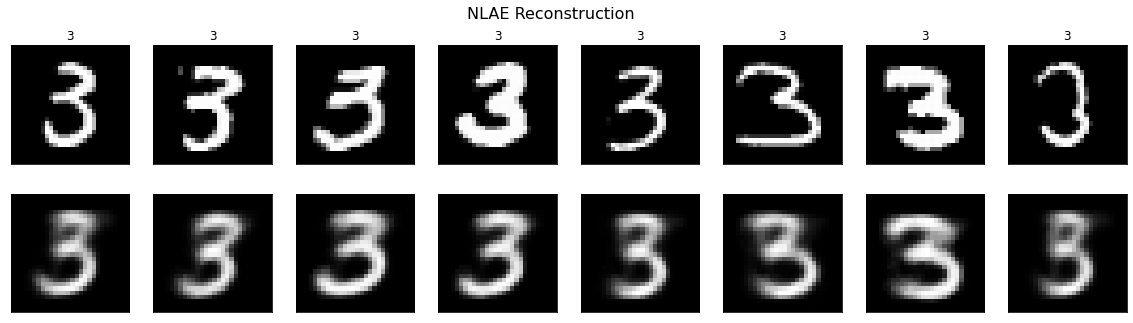

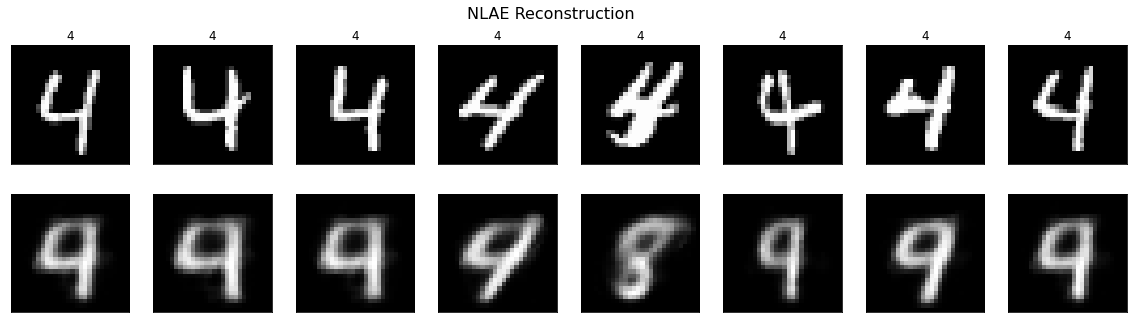

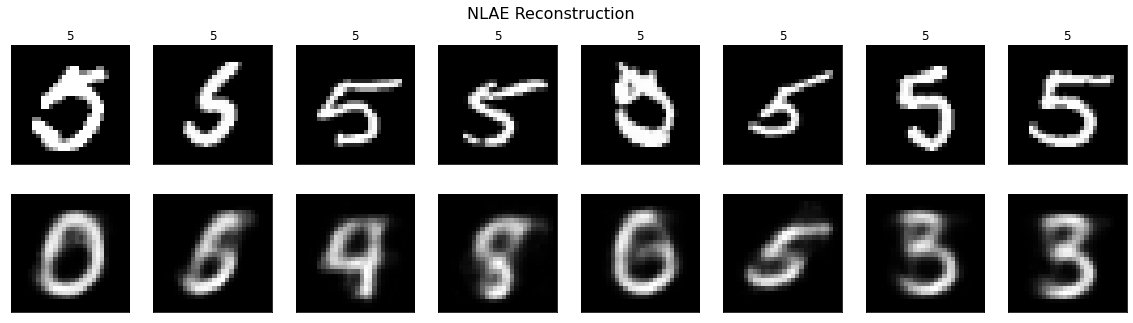

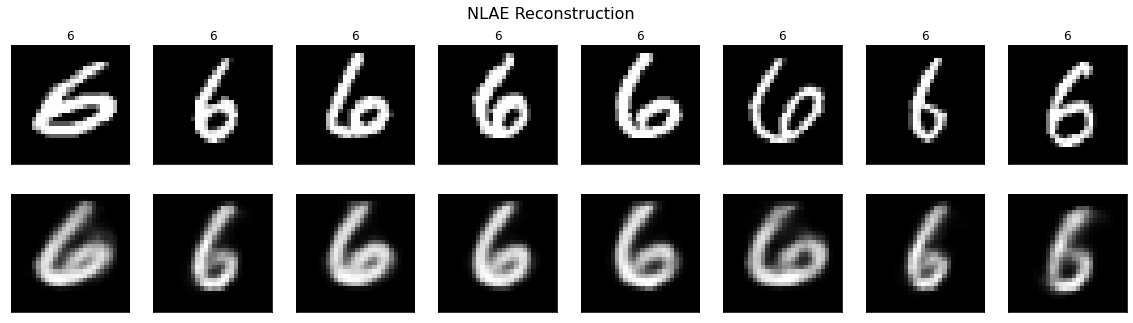

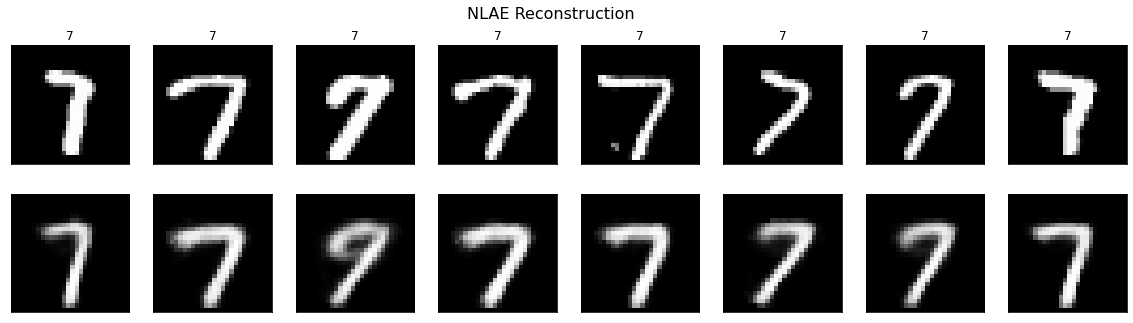

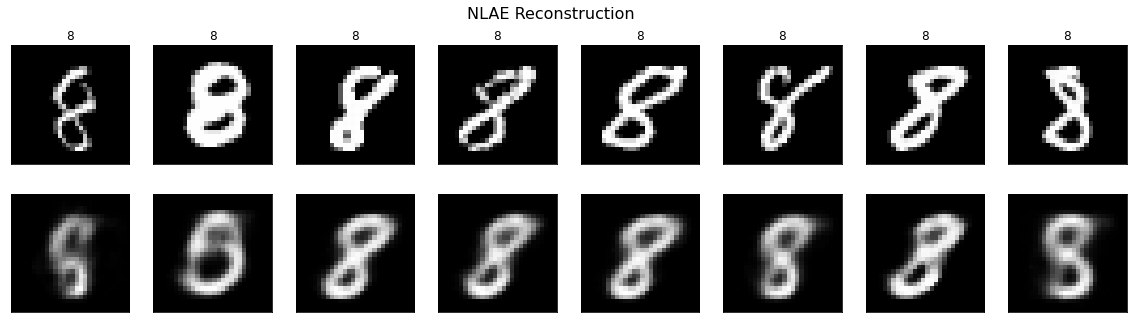

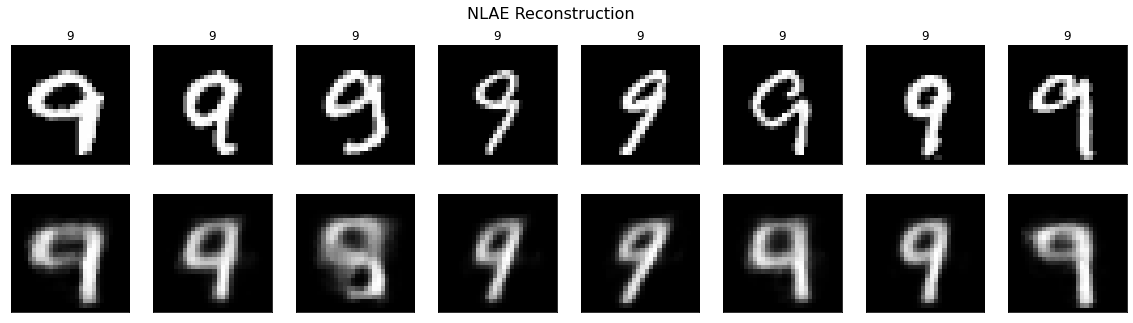

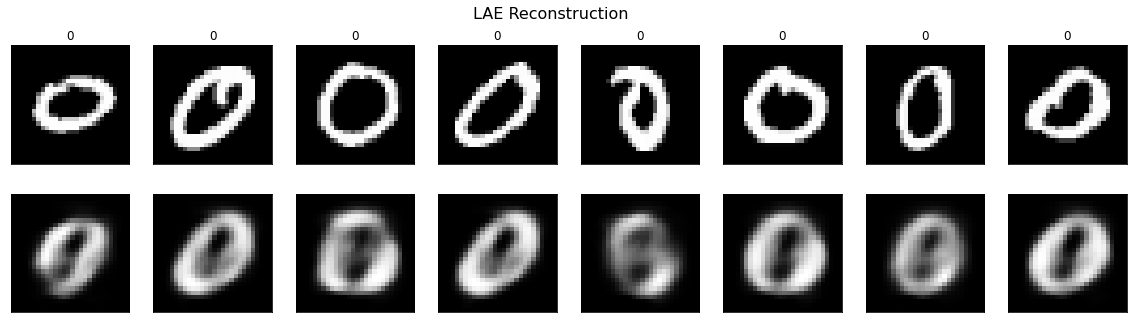

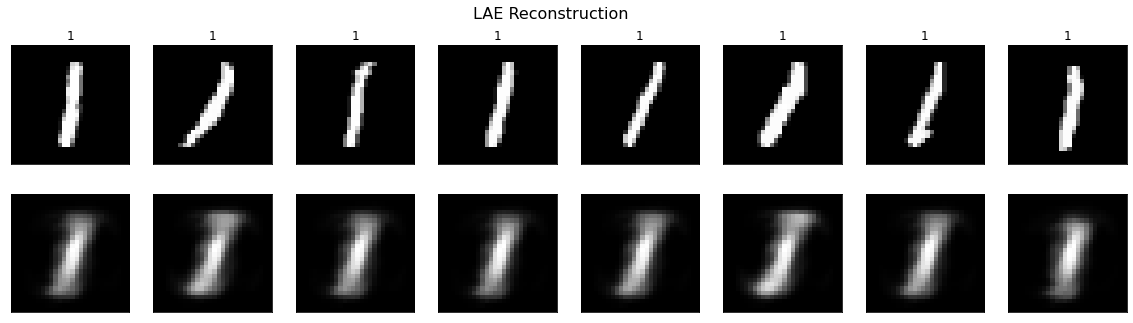

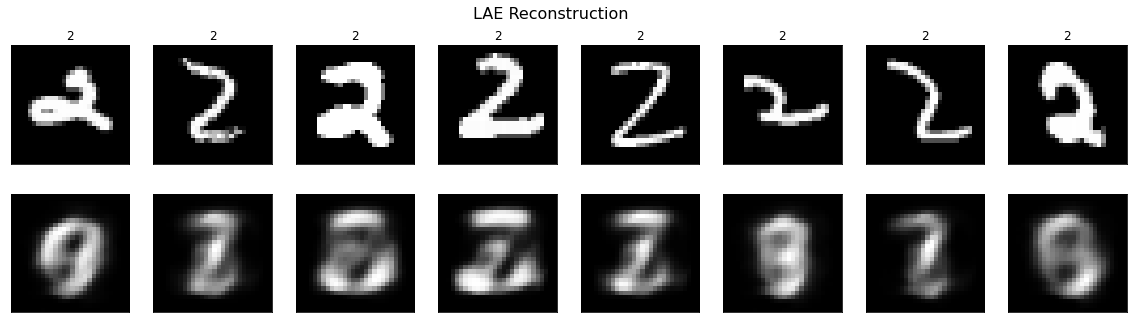

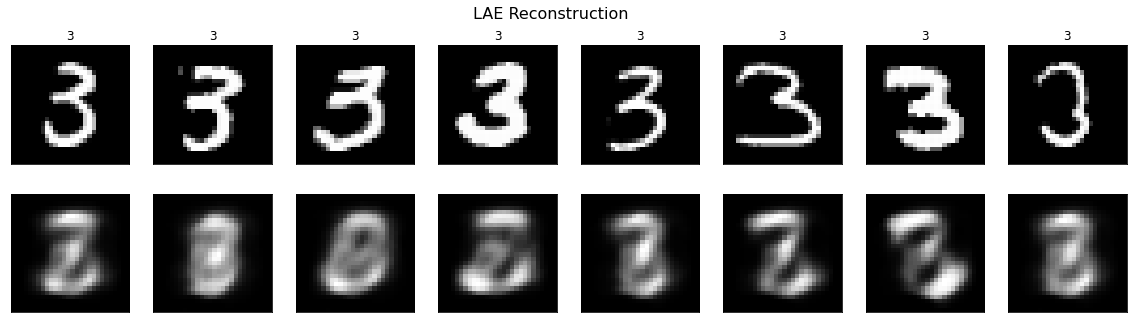

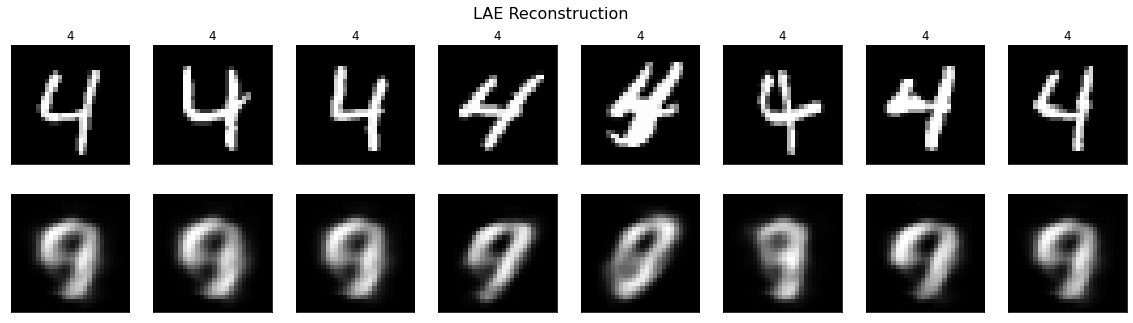

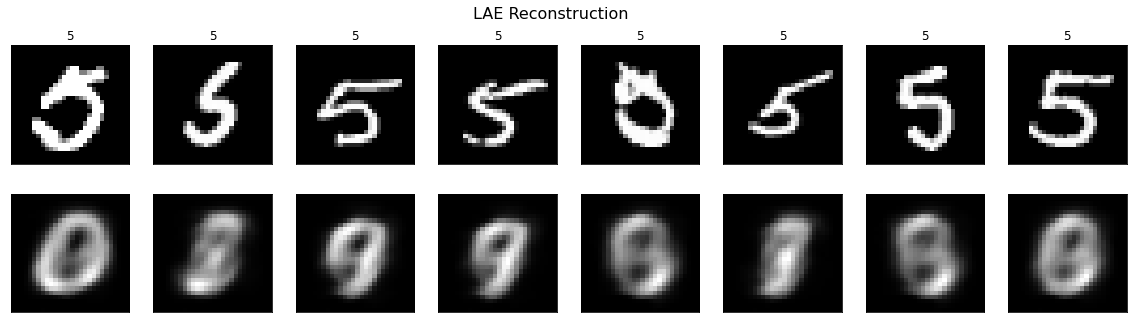

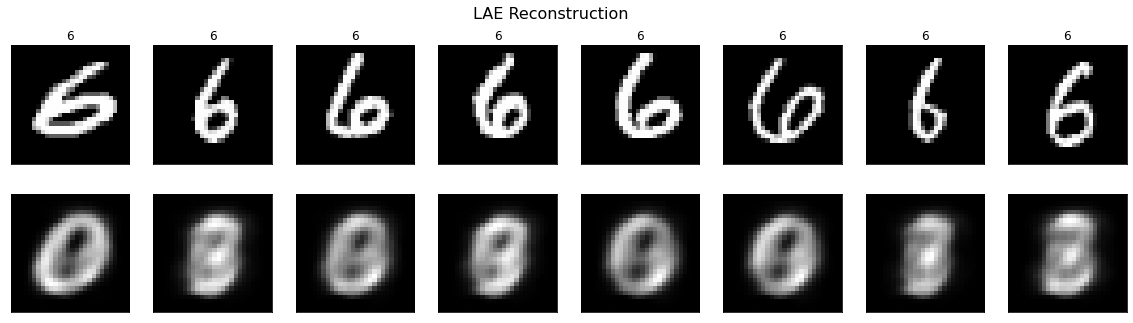

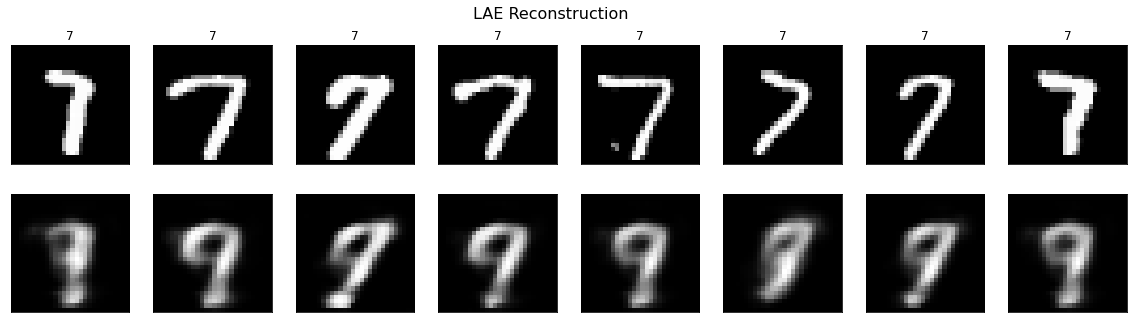

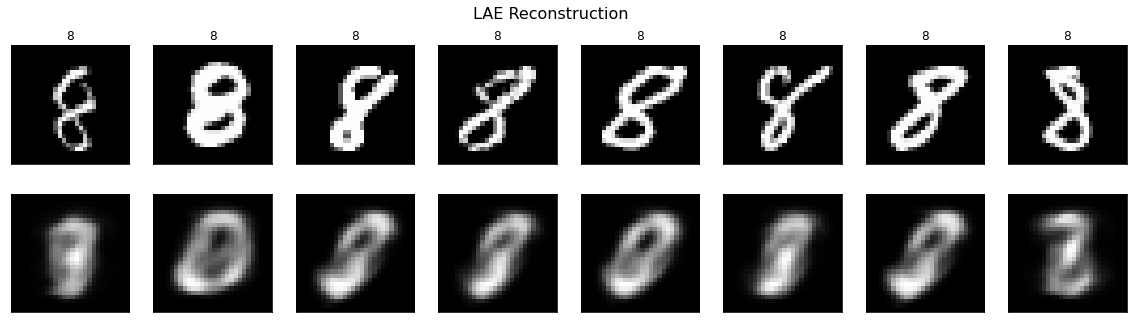

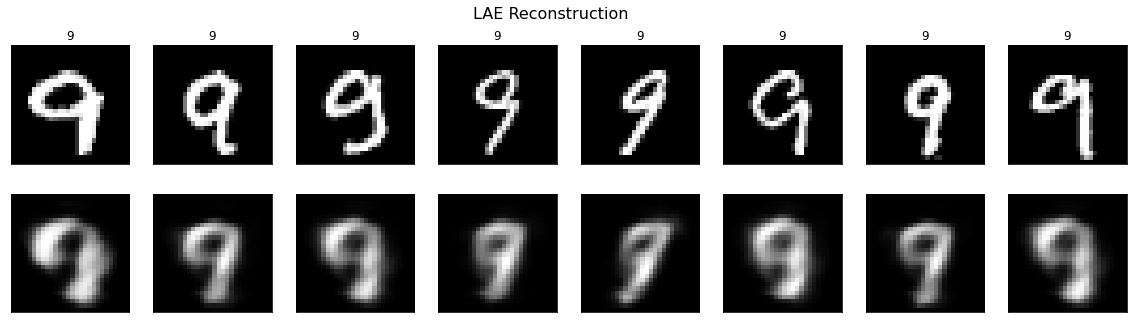

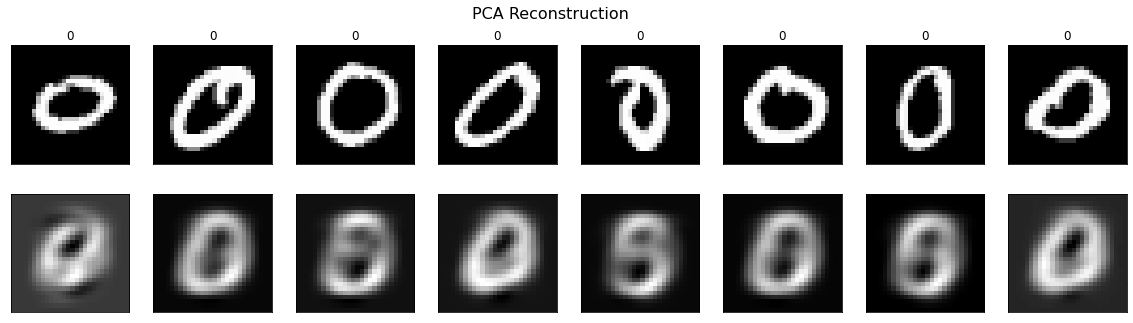

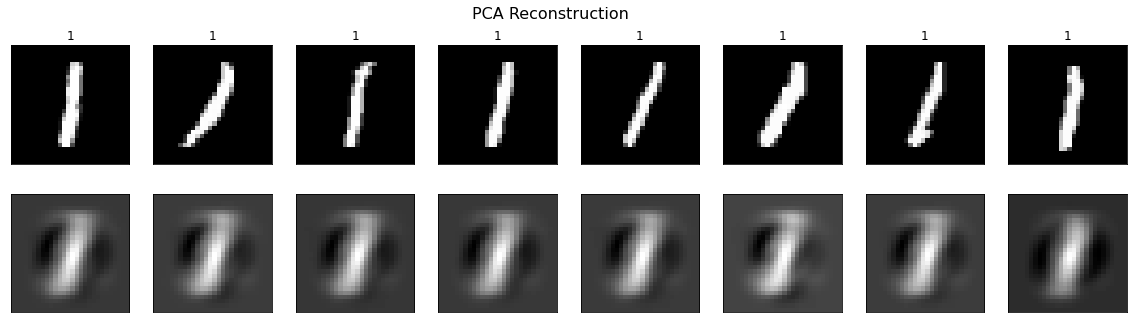

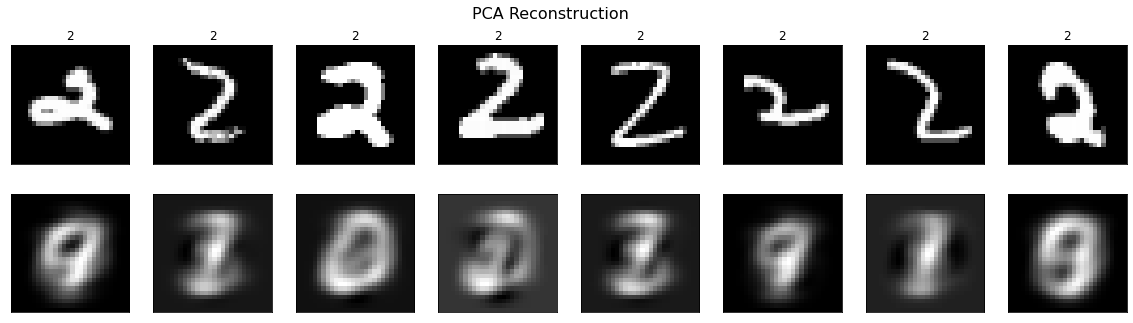

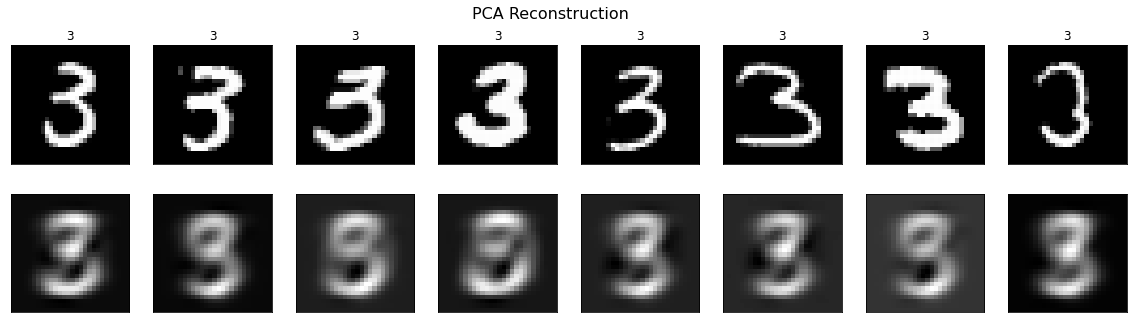

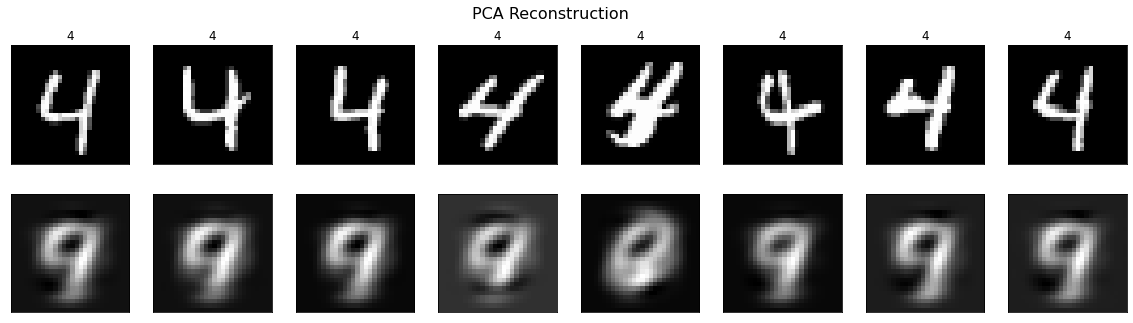

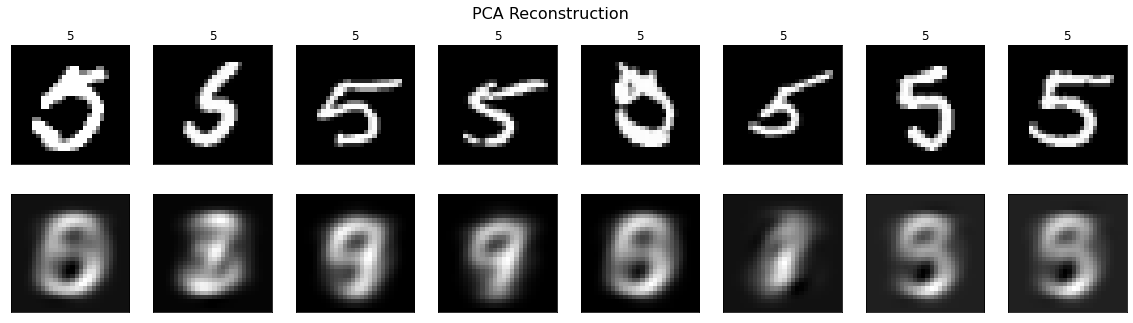

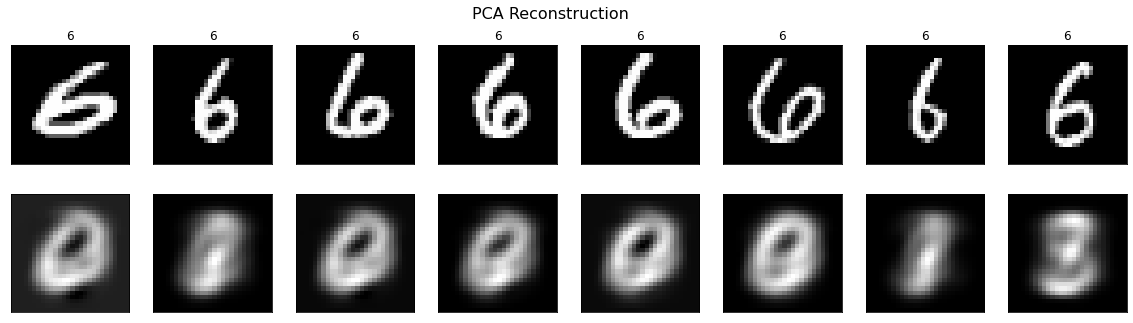

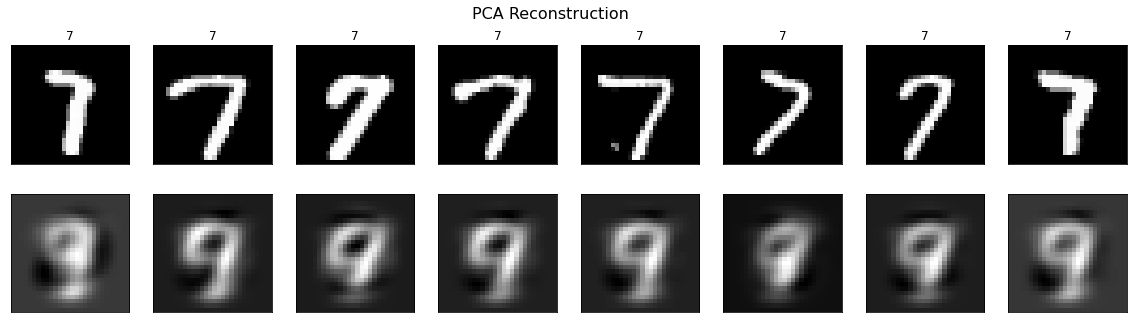

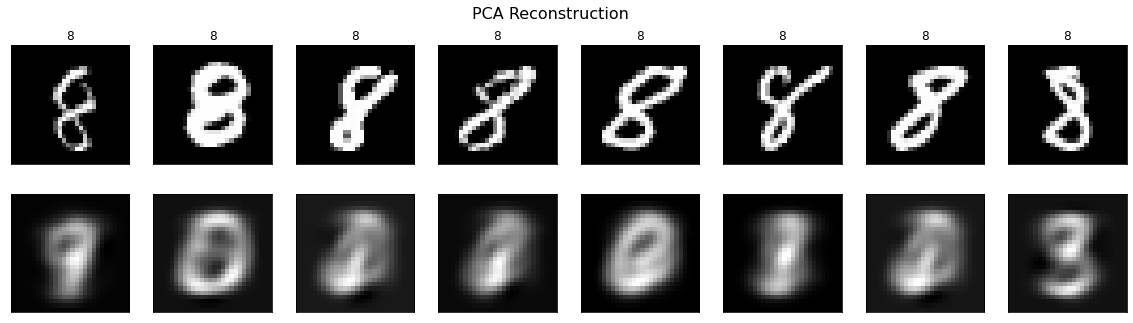

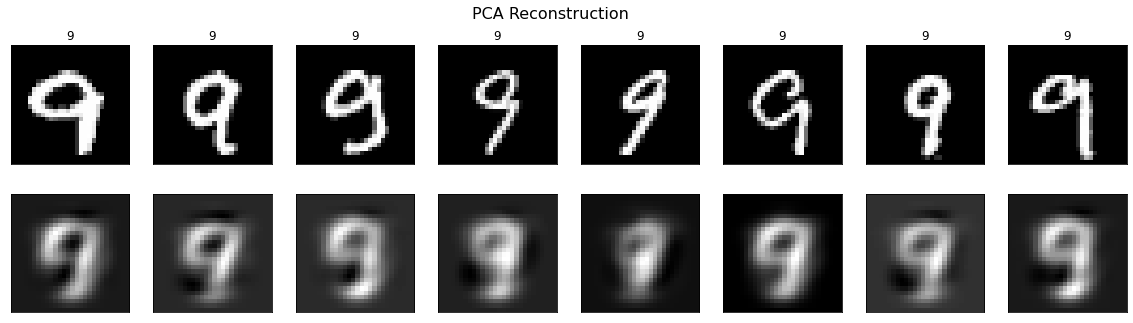

In [18]:
for model_type in ["NLAE", "LAE", "PCA"]:
    separated_original = models[model_type]["input_data_by_class"]
    separated_reconstructed = models[model_type]["output_data_by_class"]
    for i in range(len(separated_original)):
        original = separated_original[i]
        reconstructed = separated_reconstructed[i]
        visualize_reconstruction(original, reconstructed, labels=[i for _ in range(10)], model_type=model_type)